# Generative Models für Zeitreihen

**Ziel:** Generative Modelle für Anomalie-Erkennung, probabilistische Vorhersagen und Szenario-Generierung

**Modelle:**
1. Autoencoders - Für Anomalie-Erkennung
2. VAE (Variational Autoencoder) - Probabilistische Modellierung
3. GAN (Generative Adversarial Network) - Synthetische Zeitreihen
4. DeepAR - Probabilistische Vorhersagen (Amazon)

**Basierend auf:** Week08_Generative_Architectures_VAEs_GANs

**Anwendungen:**
- Anomalie-Erkennung in Energiedaten
- Unsicherheitsquantifizierung
- Worst-Case Szenario-Generation
- Data Augmentation

In [2]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from evaluation.metrics import calculate_metrics, print_metrics
from visualization.plots import plot_time_series

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")

✅ Using device: cpu


## 1. Daten laden

In [3]:
DATA_TYPE = 'solar'
data_dir = Path('../data/processed')

# Lade skalierte Daten
train_df = pd.read_csv(data_dir / f'{DATA_TYPE}_train_scaled.csv', parse_dates=['timestamp'])
val_df = pd.read_csv(data_dir / f'{DATA_TYPE}_val_scaled.csv', parse_dates=['timestamp'])
test_df = pd.read_csv(data_dir / f'{DATA_TYPE}_test_scaled.csv', parse_dates=['timestamp'])

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Train: 18262 | Val: 3913 | Test: 3914


## 2. Autoencoder für Anomalie-Erkennung

**Prinzip:**
- Lerne normale Muster aus Trainingsdaten
- Reconstruction Error = Anomalie-Score
- Hoher Error → Anomalie

In [4]:
class TimeSeriesAutoencoder(nn.Module):
    """Simple Autoencoder for anomaly detection"""
    
    def __init__(self, seq_length=24, encoding_dim=8):
        super(TimeSeriesAutoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(seq_length, 16),
            nn.ReLU(),
            nn.Linear(16, encoding_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 16),
            nn.ReLU(),
            nn.Linear(16, seq_length),
            nn.Tanh()  # Für skalierte Daten [-1, 1]
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        return self.encoder(x)

print("✅ Autoencoder defined")

✅ Autoencoder defined


In [5]:
# Erstelle Sequenzen
SEQ_LENGTH = 24

def create_sequences_ae(data, seq_length, col='value'):
    """Create sequences for autoencoder"""
    values = data[col].values
    sequences = []
    
    for i in range(len(values) - seq_length + 1):
        sequences.append(values[i:i+seq_length])
    
    return np.array(sequences)

X_train_ae = create_sequences_ae(train_df, SEQ_LENGTH)
X_val_ae = create_sequences_ae(val_df, SEQ_LENGTH)
X_test_ae = create_sequences_ae(test_df, SEQ_LENGTH)

print(f"Training sequences: {X_train_ae.shape}")

# DataLoader
train_dataset_ae = torch.utils.data.TensorDataset(
    torch.FloatTensor(X_train_ae), 
    torch.FloatTensor(X_train_ae)  # Target = Input für Autoencoder
)
train_loader_ae = DataLoader(train_dataset_ae, batch_size=64, shuffle=True)

print("✅ Data prepared for Autoencoder")

Training sequences: (18239, 24)
✅ Data prepared for Autoencoder


In [6]:
# Train Autoencoder
print("Training Autoencoder...\n")

ae_model = TimeSeriesAutoencoder(seq_length=SEQ_LENGTH, encoding_dim=8).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.001)

num_epochs = 50
losses = []

for epoch in range(num_epochs):
    ae_model.train()
    epoch_loss = 0
    
    for batch_x, batch_y in train_loader_ae:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        optimizer.zero_grad()
        reconstructed = ae_model(batch_x)
        loss = criterion(reconstructed, batch_y)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader_ae)
    losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.6f}")

print("\n✅ Autoencoder trained")

Training Autoencoder...

Epoch 10/50 - Loss: 0.227074
Epoch 20/50 - Loss: 0.225576
Epoch 30/50 - Loss: 0.225110
Epoch 40/50 - Loss: 0.224798
Epoch 50/50 - Loss: 0.224587

✅ Autoencoder trained


In [7]:
# Anomalie-Erkennung
ae_model.eval()

with torch.no_grad():
    X_test_tensor = torch.FloatTensor(X_test_ae).to(device)
    reconstructed = ae_model(X_test_tensor).cpu().numpy()

# Reconstruction Error
reconstruction_errors = np.mean(np.abs(X_test_ae - reconstructed), axis=1)

# Anomalie-Threshold (z.B. 95. Perzentil)
threshold = np.percentile(reconstruction_errors, 95)
anomalies = reconstruction_errors > threshold

print(f"\nAnomaly Detection Results:")
print(f"  Total sequences: {len(reconstruction_errors)}")
print(f"  Anomalies detected: {anomalies.sum()} ({anomalies.sum()/len(anomalies)*100:.1f}%)")
print(f"  Threshold: {threshold:.4f}")
print(f"  Max error: {reconstruction_errors.max():.4f}")


Anomaly Detection Results:
  Total sequences: 3891
  Anomalies detected: 195 (5.0%)
  Threshold: 0.7451
  Max error: 0.9884


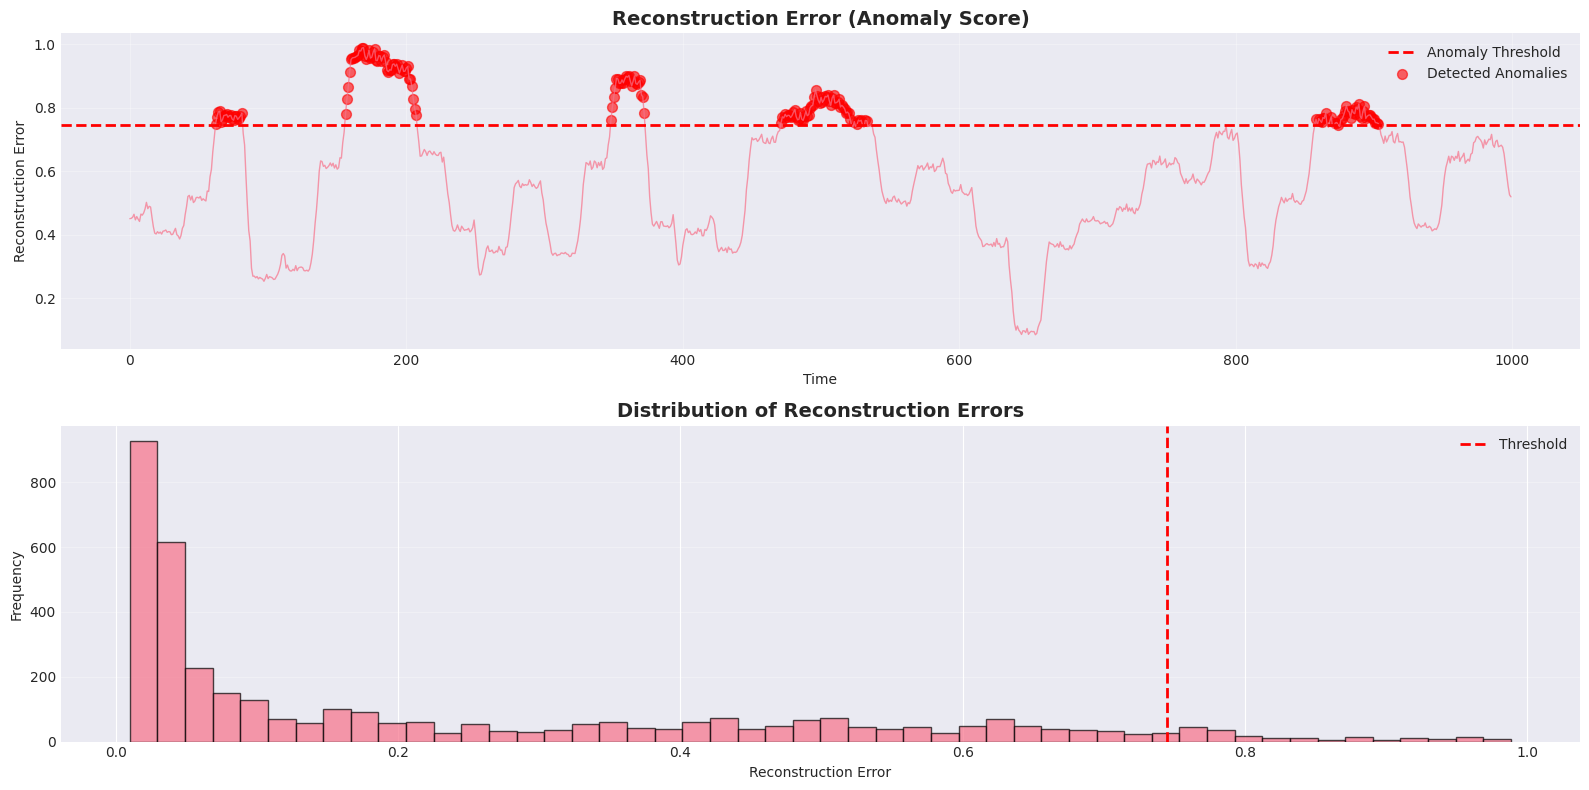

In [8]:
# Visualisierung
fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Reconstruction Error über Zeit
plot_len = min(1000, len(reconstruction_errors))
axes[0].plot(reconstruction_errors[:plot_len], alpha=0.7, linewidth=1)
axes[0].axhline(y=threshold, color='red', linestyle='--', linewidth=2, label='Anomaly Threshold')
axes[0].scatter(np.where(anomalies[:plot_len])[0], 
                reconstruction_errors[:plot_len][anomalies[:plot_len]], 
                color='red', s=50, alpha=0.6, label='Detected Anomalies')
axes[0].set_title('Reconstruction Error (Anomaly Score)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Reconstruction Error')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Histogram
axes[1].hist(reconstruction_errors, bins=50, alpha=0.7, edgecolor='black')
axes[1].axvline(x=threshold, color='red', linestyle='--', linewidth=2, label='Threshold')
axes[1].set_title('Distribution of Reconstruction Errors', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Reconstruction Error')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 3. Variational Autoencoder (VAE)

**VAE = Probabilistischer Autoencoder**

- Lernt Wahrscheinlichkeitsverteilung im Latent Space
- Kann neue Samples generieren
- Nützlich für Data Augmentation

In [9]:
class TimeSeriesVAE(nn.Module):
    """Variational Autoencoder for time series"""
    
    def __init__(self, seq_length=24, latent_dim=8):
        super(TimeSeriesVAE, self).__init__()
        
        self.seq_length = seq_length
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(seq_length, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU()
        )
        
        # Latent space parameters
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, seq_length),
            nn.Tanh()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """Reparameterization trick"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decode(z)
        return reconstructed, mu, logvar

print("✅ VAE defined")

✅ VAE defined


In [10]:
def vae_loss(reconstructed, original, mu, logvar, beta=1.0):
    """VAE Loss = Reconstruction + KL Divergence"""
    # Reconstruction loss
    recon_loss = F.mse_loss(reconstructed, original, reduction='sum')
    
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + beta * kl_loss

# Train VAE
print("Training VAE...\n")

vae_model = TimeSeriesVAE(seq_length=SEQ_LENGTH, latent_dim=8).to(device)
optimizer_vae = torch.optim.Adam(vae_model.parameters(), lr=0.001)

num_epochs_vae = 50
vae_losses = []

for epoch in range(num_epochs_vae):
    vae_model.train()
    epoch_loss = 0
    
    for batch_x, _ in train_loader_ae:
        batch_x = batch_x.to(device)
        
        optimizer_vae.zero_grad()
        reconstructed, mu, logvar = vae_model(batch_x)
        loss = vae_loss(reconstructed, batch_x, mu, logvar, beta=0.5)
        loss.backward()
        optimizer_vae.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader_ae)
    vae_losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs_vae} - Loss: {avg_loss:.2f}")

print("\n✅ VAE trained")

Training VAE...

Epoch 10/50 - Loss: 536.37
Epoch 20/50 - Loss: 527.11
Epoch 30/50 - Loss: 519.83
Epoch 40/50 - Loss: 504.98
Epoch 50/50 - Loss: 502.97

✅ VAE trained


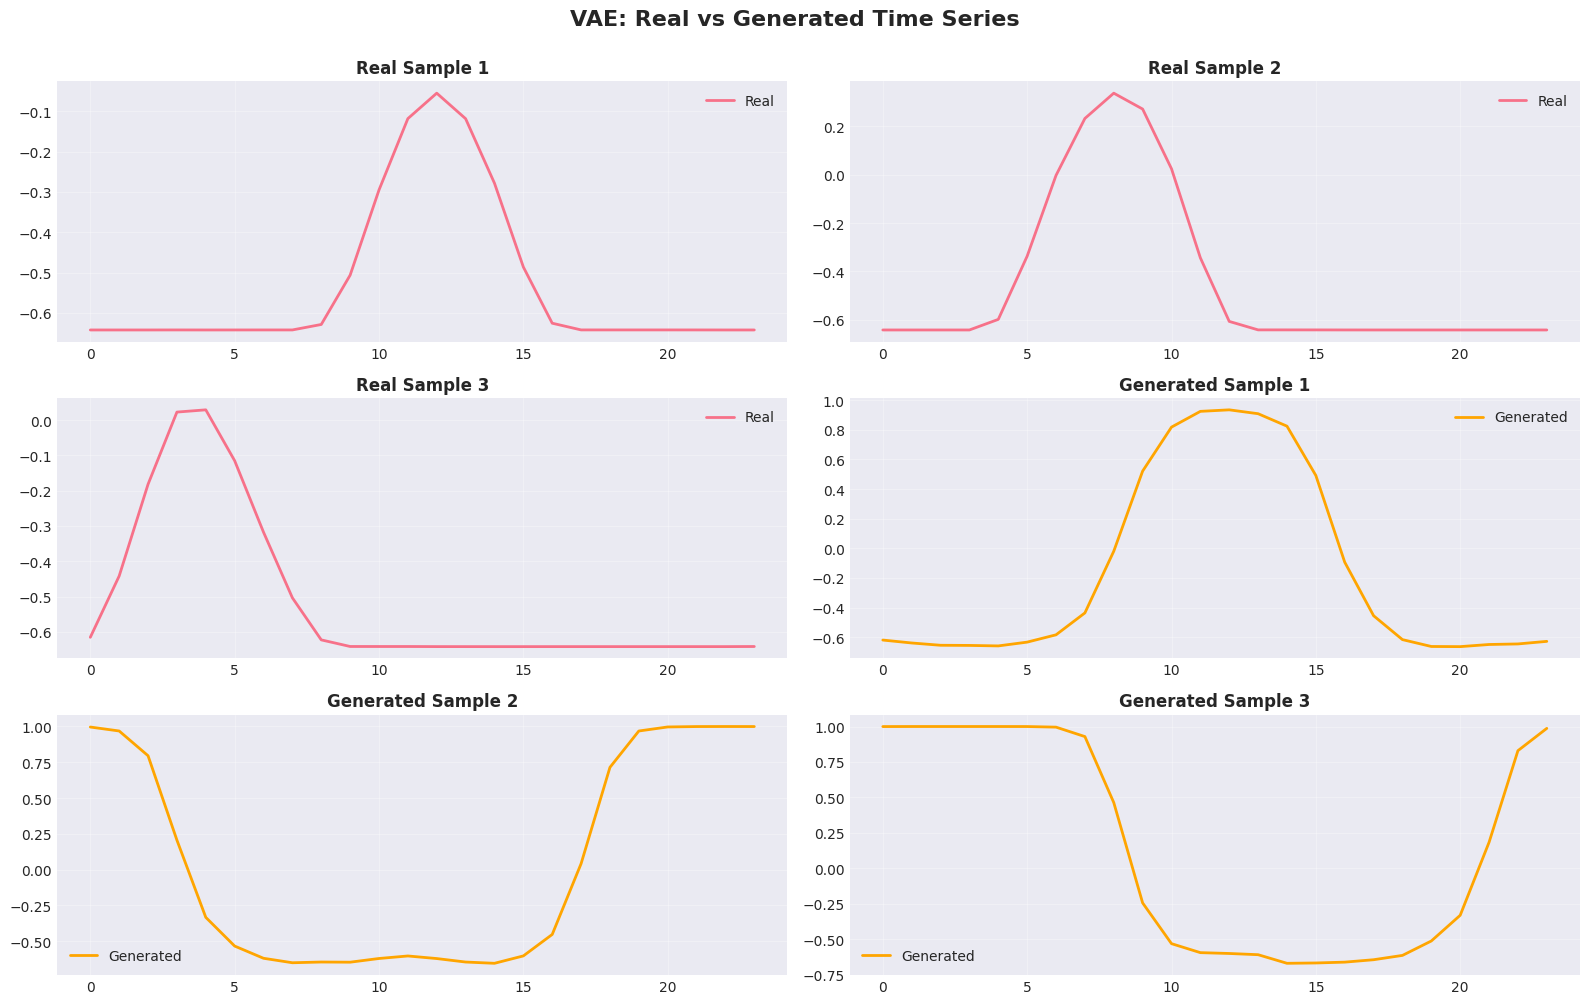


✅ Generated 5 synthetic time series


In [11]:
# Generiere neue synthetische Zeitreihen
vae_model.eval()

with torch.no_grad():
    # Sample from latent space
    z_samples = torch.randn(5, vae_model.latent_dim).to(device)
    generated_sequences = vae_model.decode(z_samples).cpu().numpy()

# Visualisierung
fig, axes = plt.subplots(3, 2, figsize=(16, 10))
axes = axes.flatten()

# Echte Beispiele
for i in range(3):
    axes[i].plot(X_train_ae[i*100], label='Real', linewidth=2)
    axes[i].set_title(f'Real Sample {i+1}', fontweight='bold')
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()

# Generierte Beispiele
for i in range(3):
    axes[i+3].plot(generated_sequences[i], label='Generated', color='orange', linewidth=2)
    axes[i+3].set_title(f'Generated Sample {i+1}', fontweight='bold')
    axes[i+3].grid(True, alpha=0.3)
    axes[i+3].legend()

plt.suptitle('VAE: Real vs Generated Time Series', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(f"\n✅ Generated {len(generated_sequences)} synthetic time series")

## 4. GAN (Generative Adversarial Network)

**GAN = Generator vs Discriminator**

- Generator erstellt synthetische Zeitreihen
- Discriminator unterscheidet echt/fake
- Training = Adversarial Game

In [12]:
class Generator(nn.Module):
    """Generate synthetic time series from noise"""
    
    def __init__(self, noise_dim=10, seq_length=24):
        super(Generator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, seq_length),
            nn.Tanh()
        )
    
    def forward(self, z):
        return self.model(z)


class Discriminator(nn.Module):
    """Distinguish real from fake time series"""
    
    def __init__(self, seq_length=24):
        super(Discriminator, self).__init__()
        
        self.model = nn.Sequential(
            nn.Linear(seq_length, 64),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)

print("✅ GAN models defined")

✅ GAN models defined


In [13]:
# Train GAN
print("Training GAN...\n")
print("⚠️ GAN Training kann instabil sein!\n")

NOISE_DIM = 10
generator = Generator(noise_dim=NOISE_DIM, seq_length=SEQ_LENGTH).to(device)
discriminator = Discriminator(seq_length=SEQ_LENGTH).to(device)

criterion_gan = nn.BCELoss()
optimizer_g = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

num_epochs_gan = 100
g_losses, d_losses = [], []

for epoch in range(num_epochs_gan):
    g_loss_epoch = 0
    d_loss_epoch = 0
    
    for batch_x, _ in train_loader_ae:
        batch_size = batch_x.size(0)
        real_data = batch_x.to(device)
        
        # Labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)
        
        # Train Discriminator
        optimizer_d.zero_grad()
        
        # Real data
        d_real = discriminator(real_data)
        d_loss_real = criterion_gan(d_real, real_labels)
        
        # Fake data
        noise = torch.randn(batch_size, NOISE_DIM).to(device)
        fake_data = generator(noise)
        d_fake = discriminator(fake_data.detach())
        d_loss_fake = criterion_gan(d_fake, fake_labels)
        
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_d.step()
        
        # Train Generator
        optimizer_g.zero_grad()
        
        noise = torch.randn(batch_size, NOISE_DIM).to(device)
        fake_data = generator(noise)
        d_fake = discriminator(fake_data)
        g_loss = criterion_gan(d_fake, real_labels)  # Generator wants D to think it's real
        
        g_loss.backward()
        optimizer_g.step()
        
        g_loss_epoch += g_loss.item()
        d_loss_epoch += d_loss.item()
    
    g_losses.append(g_loss_epoch / len(train_loader_ae))
    d_losses.append(d_loss_epoch / len(train_loader_ae))
    
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{num_epochs_gan} - D Loss: {d_losses[-1]:.4f} - G Loss: {g_losses[-1]:.4f}")

print("\n✅ GAN trained")

Training GAN...

⚠️ GAN Training kann instabil sein!

Epoch 20/100 - D Loss: 0.9792 - G Loss: 1.3994
Epoch 40/100 - D Loss: 0.9764 - G Loss: 1.1594
Epoch 60/100 - D Loss: 0.9732 - G Loss: 1.1299
Epoch 80/100 - D Loss: 0.9672 - G Loss: 1.1280
Epoch 100/100 - D Loss: 0.9641 - G Loss: 1.1301

✅ GAN trained


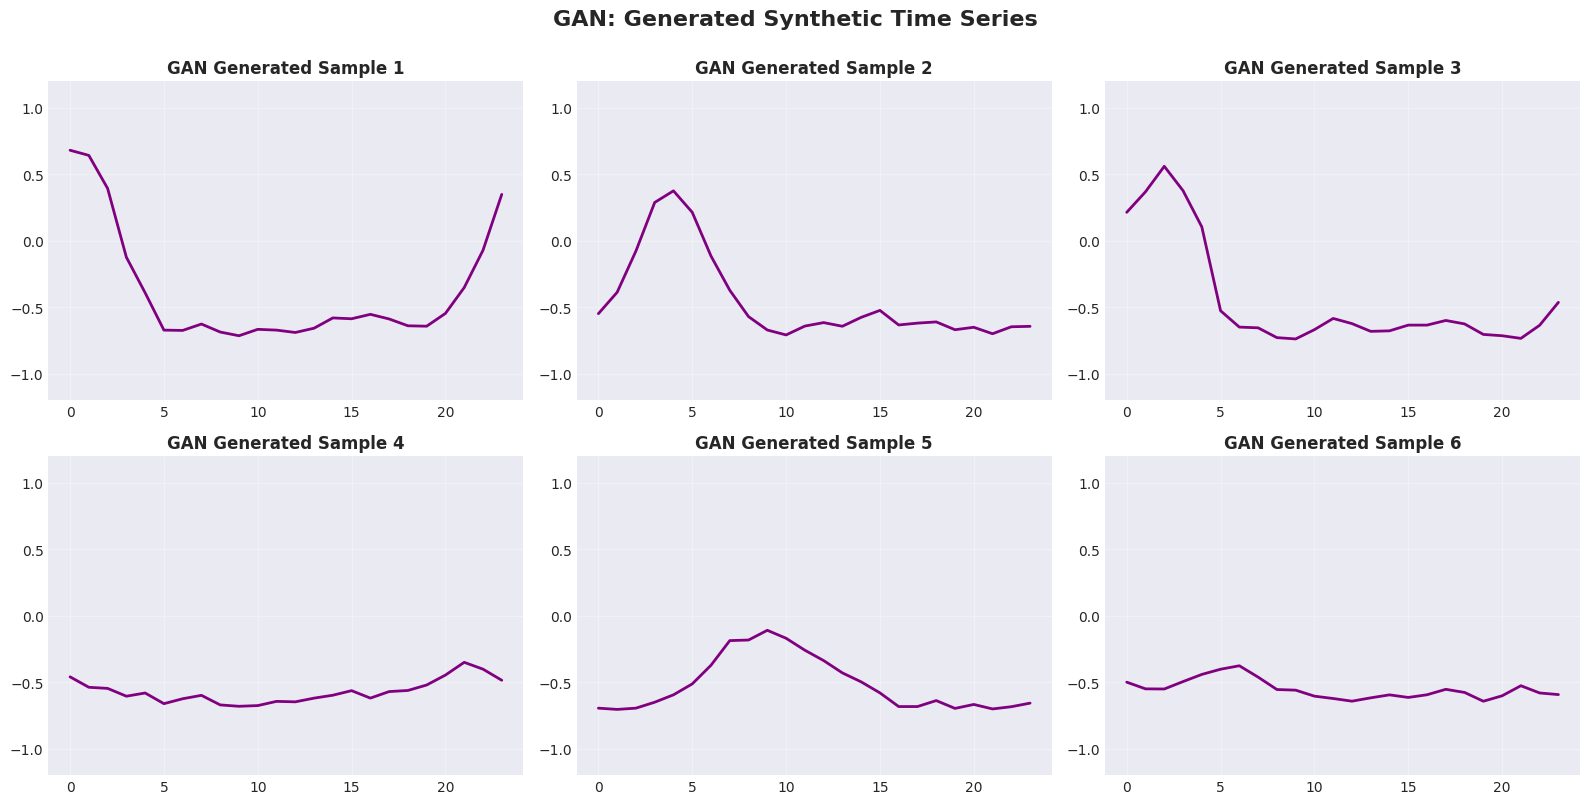

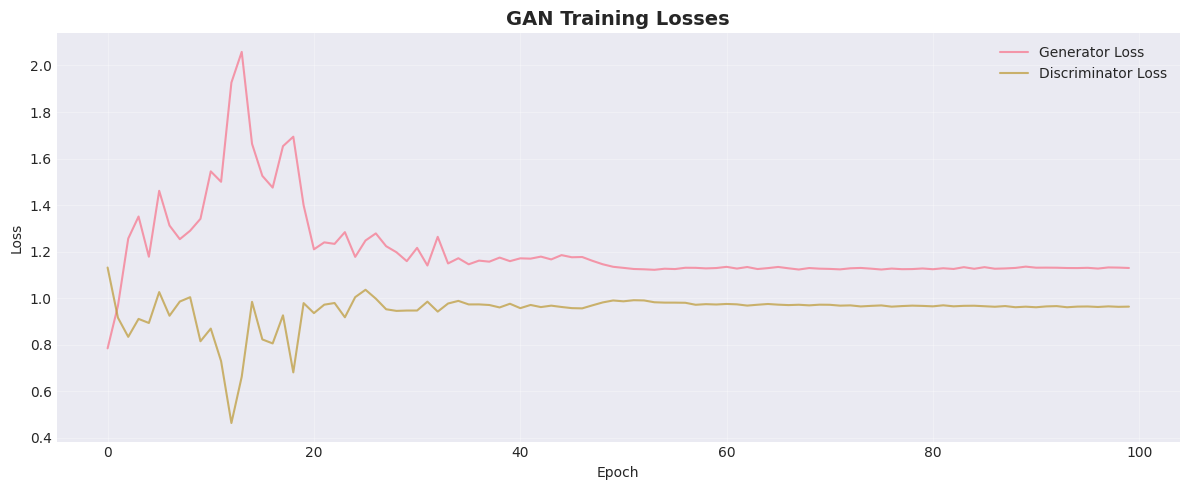

In [14]:
# Generiere synthetische Zeitreihen mit GAN
generator.eval()

with torch.no_grad():
    noise = torch.randn(6, NOISE_DIM).to(device)
    gan_generated = generator(noise).cpu().numpy()

# Visualisierung
fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

for i in range(6):
    axes[i].plot(gan_generated[i], linewidth=2, color='purple')
    axes[i].set_title(f'GAN Generated Sample {i+1}', fontweight='bold')
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim(-1.2, 1.2)

plt.suptitle('GAN: Generated Synthetic Time Series', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# GAN Learning Curves
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(g_losses, label='Generator Loss', alpha=0.7)
ax.plot(d_losses, label='Discriminator Loss', alpha=0.7)
ax.set_title('GAN Training Losses', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. DeepAR - Probabilistic Forecasting

**DeepAR (Amazon Research)**

- Autoregressive RNN mit probabilistischen Outputs
- Quantile-Vorhersagen (P10, P50, P90)
- Unsicherheitsquantifizierung

**Hinweis:** Für vollständige Implementation siehe `gluonts` oder `pytorch-forecasting`

In [15]:
print("\n" + "="*80)
print("DeepAR - Probabilistic Forecasting")
print("="*80)
print("""
DeepAR ist besonders nützlich für:

1. **Unsicherheitsquantifizierung**
   - Nicht nur Punktvorhersage, sondern Wahrscheinlichkeitsverteilung
   - P10, P50 (Median), P90 Quantile

2. **Risikoanalyse**
   - Worst-Case Szenarien (P10)
   - Best-Case Szenarien (P90)
   - Planungssicherheit

3. **Multiple Time Series**
   - Lernt übergreifende Muster
   - Transfer Learning

**Vollständige Implementation:**

```python
# Option 1: GluonTS (MXNet)
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer

estimator = DeepAREstimator(
    freq="H",
    prediction_length=24,
    trainer=Trainer(epochs=50)
)

# Option 2: PyTorch Forecasting
from pytorch_forecasting import DeepAR

model = DeepAR.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=32,
    rnn_layers=2
)
```

**Für dieses Projekt:** Siehe Notebook 08_advanced_models.ipynb für TFT,
welches ähnliche probabilistische Outputs bietet.
""")
print("="*80)


DeepAR - Probabilistic Forecasting

DeepAR ist besonders nützlich für:

1. **Unsicherheitsquantifizierung**
   - Nicht nur Punktvorhersage, sondern Wahrscheinlichkeitsverteilung
   - P10, P50 (Median), P90 Quantile

2. **Risikoanalyse**
   - Worst-Case Szenarien (P10)
   - Best-Case Szenarien (P90)
   - Planungssicherheit

3. **Multiple Time Series**
   - Lernt übergreifende Muster
   - Transfer Learning

**Vollständige Implementation:**

```python
# Option 1: GluonTS (MXNet)
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer

estimator = DeepAREstimator(
    freq="H",
    prediction_length=24,
    trainer=Trainer(epochs=50)
)

# Option 2: PyTorch Forecasting
from pytorch_forecasting import DeepAR

model = DeepAR.from_dataset(
    training,
    learning_rate=0.001,
    hidden_size=32,
    rnn_layers=2
)
```

**Für dieses Projekt:** Siehe Notebook 08_advanced_models.ipynb für TFT,
welches ähnliche probabilistische Outputs bietet.



## 6. Zusammenfassung & Anwendungen

### Modell-Übersicht:

| Modell | Hauptanwendung | Output |
|--------|----------------|--------|
| **Autoencoder** | Anomalie-Erkennung | Reconstruction Error |
| **VAE** | Data Augmentation, Generierung | Probabilistische Samples |
| **GAN** | Synthetische Daten, Stress-Tests | Realistische Samples |
| **DeepAR** | Probabilistische Vorhersagen | Quantilen (P10, P50, P90) |

### Praktische Anwendungen im Energiesektor:

1. **Anomalie-Erkennung (Autoencoder)**
   - Ungewöhnliche Netzschwankungen
   - Geräteausfälle
   - Cyber-Attacken

2. **Szenario-Generierung (VAE, GAN)**
   - Worst-Case Szenarien für Kapazitätsplanung
   - Data Augmentation für Training
   - Stress-Tests

3. **Unsicherheitsquantifizierung (DeepAR)**
   - Risikoanalyse
   - Planungssicherheit
   - Reserven-Berechnung

### Erkenntnisse:

✅ **Autoencoders** einfach und effektiv für Anomalie-Erkennung  
✅ **VAEs** flexibler als Autoencoders, probabilistisch  
✅ **GANs** können sehr realistische Samples generieren, aber instabil  
✅ **DeepAR** ideal für Unsicherheitsquantifizierung  

### Nächste Schritte:

→ **08_advanced_models.ipynb** für TFT, N-BEATS, N-HiTS

In [16]:
# Speichere Modelle
models_dir = Path('../models')
models_dir.mkdir(parents=True, exist_ok=True)

torch.save(ae_model.state_dict(), models_dir / 'autoencoder.pth')
torch.save(vae_model.state_dict(), models_dir / 'vae.pth')
torch.save(generator.state_dict(), models_dir / 'gan_generator.pth')
torch.save(discriminator.state_dict(), models_dir / 'gan_discriminator.pth')

print("✅ Generative Modelle gespeichert")

✅ Generative Modelle gespeichert
